# Задача

Найти минимум функции на множестве: $$\min\limits_{x\in X}f(x)$$

## Множество

$X\in\mathbb{R}^n$, $n\in\{100, 200, 500, 1000\}$

1. $X$ симплекс
2. $X$ сфера

## Функция

$$f(x) = x^TAx - b^Tx$$

$А$ — 
* случайная [0,L] матрица
* элементы равномерно распределены
* регуляризованная как 
$A - \lambda_{\min}(A)I$, где $I$ — единичная матрица

Я использую другой вариант генерации (см. ниже), т.к. предложенный не гарантирует симметричность, а также получается неконтролируемый разброс собственных чисел. Из-за этого градиентный спуск начинает ужасно тормозить

## Методы
1. Градиентный спуск (Правило Армихо, критерий остановки) +
2. Субградиенты (постоянный шаг, Шаг по Поляку) (???)
3. Зеркальный спуск с Энтропийным сетапом  +
4. Быстрые градиенты Нестерова+
5. Градиентный спуск в 1 норме (если дойдем) (???)

## Графики

1. Производительность (???)
2. Убывание функционала либо невязки +

## Библиотеки

In [2]:
import numpy as np
from numpy import linalg
%matplotlib inline
import matplotlib.pyplot as plt

$$A=S^TDS$$
S получается ортогонализацией Грамма-Шмидта из случайной матрицы, D задается явно ниже

In [119]:
# Размерность пространства
n=500
# Случайная матрица
S0=np.random.randn(n,n)

# Ортогонализация Грамма-Шмидта
S=np.copy(S0)
for i in range(n):
    S[i] = np.copy(S0[i])
    for j in range(i):
        S[i] -= S[j] * np.dot(S[i], S[j]) / np.dot(S[j], S[j])
    S[i] /= np.sqrt(np.dot(S[i], S[i]))

# Проверяем ортогональность
np.allclose(np.dot(S.T,S), np.eye(n))

True

In [120]:
# Собственные числа матрицы A
D=np.diag(np.linspace(1, 50, num = n))
A=np.dot(S.T, np.dot(D, S))
# Вектор b

In [121]:
b=np.random.rand(n)

## Функция
$$f(x)=\frac{1}{2}x^TAx-b^Tx$$

In [93]:
# Градиент функции
def grad(x):
    return(np.dot(A, x) - b)

In [94]:
# Функция
def func(x):
    return(0.5 * np.dot(x.T, np.dot(A, x))-np.dot(b, x))

## Проекция на S
$$S=B^{||\cdot||_2}_1(0)$$

In [95]:
def p(x):
    norm = linalg.norm(x)
    if norm <= 1:
        return(x)
    else:
        return(x / norm)
def dist(x):
    return(linalg.norm(x - p(x)))

## Графики по последовательности $\{x_k\}$

In [96]:
def method_info(x):
    y = np.zeros((len(x)))
    x_dist = np.zeros((len(x)))
    step = np.zeros((len(x)))

    for i in range(len(x)):
        y[i] = func(x[i])
        x_dist[i] = linalg.norm(x[i]-p(x[i]))
        
        if i >= 1:
            step[i] = linalg.norm(x[i] - x[i - 1])
        
    imin = np.argmin(y)
    y -= func(x[imin])
    
    x_diff_norm = linalg.norm(x[:]-x[imin], axis=1)

    ms = 3
    
    print "Best: " + str(imin) + " f = " + str(func(x[imin]))
    print "Last: " + str(len(x))
    
    plt.figure(figsize=(10,10))
    plt.subplot(3, 1, 1)
    plt.plot(x_diff_norm, 'g.', label=r"$||x_i-x_{best}||$", ms=ms)
    plt.legend(loc='upper right', fontsize=18)
    #plt.xlabel('$i$', fontsize=25)
    
    plt.subplot(3, 1, 2)
    plt.plot(step, 'b.', label=r"$||x_i-x_{i-1}||$", ms=ms)
    plt.legend(loc='upper right', fontsize=18)
    #plt.xlabel('$i$', fontsize=25)
    
    plt.subplot(3, 1, 3)
    plt.plot(y, 'r.', label=r"$f(x_i)-f(x_{best})$", ms=ms)
    plt.legend(loc='upper right', fontsize=18)
    plt.xlabel('$i$', fontsize=25)
    
    #plt.savefig("chart.png")

    # display plot on screen
    plt.show()

## Армихо
Поиск шага по x, $\alpha_0$, $\theta$, $\varepsilon$

In [53]:
def armiho(x, a0, theta, eps):
    # Выбор шага по Армихо
    a = a0
    grad_norm_2 = np.linalg.norm(grad(x)) ** 2
    while True:
        x_new = x - a * grad(x)
        if func(x_new) - func(x) + eps * a * grad_norm_2 < 0:
            break
        a *= theta
    return a

## Метод проекции градиента
$$t_{k+1}=\pi_{X}(x_k-\alpha_k\nabla f(x_k))$$
$$x_{k+1}=(1-v)x_k+vt_{k+1}$$

Последняя строчка подсказана Дорном, иначе метод "застревает"

Выбор $\alpha_k$ по Армихо

In [129]:
# Массив с точками
x = list()
x.append(np.zeros(n))
i = 1

# Выбор шага по Армихо, параметры
a0 = 1
theta = 0.1
eps = 0.1

# Условия остановки
grad_norm=1e-6
maxiter=100
x_norm=1e-6

v = 0.4

while True:
    x.append(0)
    
    a = armiho(x[i - 1], a0, theta, eps)
    # Градиентный шаг
    x[i] = x[i - 1] - a * grad(x[i - 1])
    
    #
    proj = np.copy(p(x[i]))
    x[i] = (1 - v) * x[i - 1] + v * proj
    
    norm_new = np.linalg.norm(grad(x[i]))
    #print a, x[i], func(x[i]), norm_new, dist(x[i])
    
    # Условия останова
    if norm_new < grad_norm:
        break
    
    if np.linalg.norm(proj - x[i - 1]) < x_norm:
        break
    
    if i >= maxiter:
        break
        
    i += 1

Best: 85 f = -5.99937415975
Last: 86


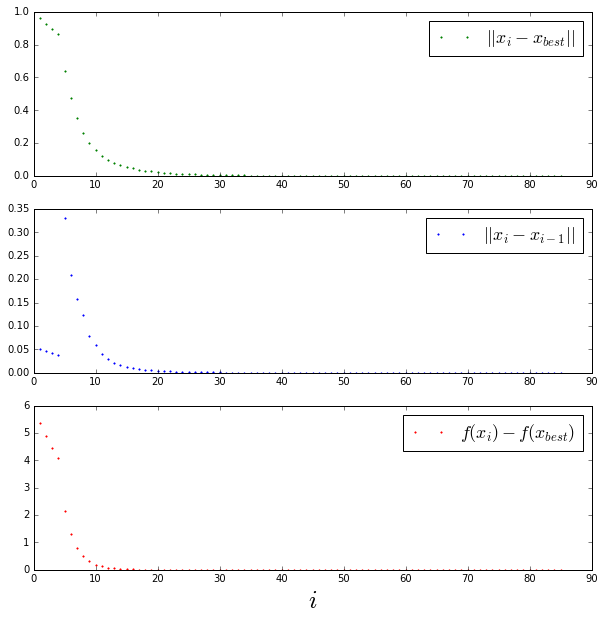

In [130]:
method_info(x)

## Быстрые градиенты Нестерова
Последовательность $\{\lambda_k\}_{k=0}^\infty$: $\lambda_0=0$,
$$\lambda_{k+1}=\frac{1+\sqrt{1+4\lambda_{k}^2}}{2}$$

Последовательность $\{\gamma_s\}$:
$$\gamma_s=\frac{1-\lambda_s}{\lambda_{s+1}}$$

### Шаг:

0. $x_1=y_1$ --- начальная точка
1. $y_{s+1}=x_s-\frac{1}{\beta}\nabla f(x_s)$
2. $x_{s+1}=(1-\gamma_s)y_{s+1}+\gamma_sy_s$

$\beta$ --- из требования: $f$ --- $\beta$-гладкая.

По аналогии (шаг в направлении градиента) величина $1/\beta$ тут считается по Армихо

In [79]:
def newl(l):
    return((1 + np.sqrt(1 + 4 * l ** 2)) / 2)
def gamma(l, s):
    return((1-l[s])/l[s+1])

In [80]:
# Массив с точками
l = list()
x = list()
y = list()
x.append(np.zeros(n))
y.append(x[0])
y.append(x[0])
x.append(x[0])
l.append(0)
l.append(newl(0))
s = 1

# Условия остановки
#grad_norm=1e-5
#maxiter=10000
#x_norm=1e-5

while True:
    x.append(0)
    y.append(0)
    l.append(0)
    
    a = armiho(x[s], 1, 0.8, 0.3)
    
    l[s + 1] = newl(l[s])
    g = (1 - l[s]) / l[s + 1]
    
    y[s + 1] = x[s] - a * grad(x[s])
    x[s + 1] = (1 - g) * y[s + 1] + g * y[s]
    
    norm_new = np.linalg.norm(grad(x[s + 1]))
    #print a, g, l[s + 1], func(x[s + 1]), norm_new
    
    # Условия останова
    if norm_new < grad_norm:
        break
    
    if np.linalg.norm(x[s + 1] - x[s]) < x_norm:
        break
    
    if s >= maxiter:
        break
        
    s += 1

Best: 101 f = -14.1297705437
Last: 102


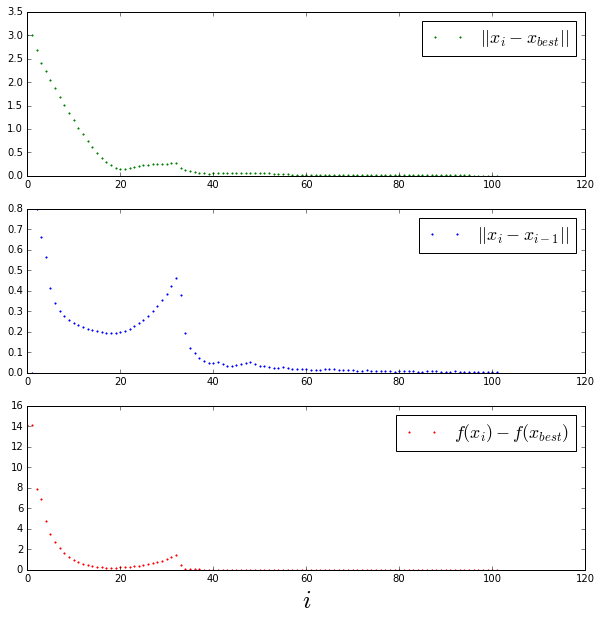

In [81]:
method_info(x)

## Mirror Descent

$$X = \{x\in\mathbb{R}^n_+\big| ||x||_1\equiv\sum\limits_{i=1}^nx_i\leqslant1\}$$
$$\varPhi(x)=\sum\limits_{i=1}^nx_i\ln x_i$$

Найдем $\frac{\partial \varPhi(\vec{x})}{\partial x_i}=\ln x_i + 1$, откуда
$$\nabla \varPhi(x)=||(1+\ln x_1)\,...\,(1+\ln x_n)||^T$$

$\varPhi^*(p)=\sup\limits_{x\in\mathbb{R}^n_+}(p^Tx-\varPhi(x))$. Продифференцируем, получим $p=\nabla\varPhi(x)$, откуда $x_i=e^{p_i-1}$. Подставим $x_i$, получим $\varPhi^*(p)=\sum\limits_{i=1}^n e^{p_i-1}$

Найдем $\frac{\partial \varPhi^*(p)}{\partial p_i}=e^{p_i-1}$, откуда
$$\nabla\varPhi^*(p)=||e^{p_1-1}\,...\,e^{p_n-1}||^T$$

Проверим, что $\nabla\varPhi^*(p)=(\nabla\varPhi(x))^{-1}$:
$$\nabla\varPhi^*(\nabla\varPhi(x))=\nabla\varPhi^*(||(1+\ln x_1)\,...\,(1+\ln x_n)||^T)=\vec{x}\,\blacksquare$$

Найдем $D_\varPhi(x,y)=\varPhi(x)-\varPhi(y)-(\nabla\varPhi(y),x-y)=\sum\limits_{i=1}^nx_i\ln x_i - y_i\ln y_i + (y_i - x_i)(1 + \ln y_i)=\sum\limits_{i=1}^n(y_i-x_i+x_i\ln\frac{x_i}{y_i})$

Пусть $y\in\mathbb{R}^n_+$. Тогда
$$\arg\min_{x\in X}D_\varPhi(x,y)=\frac{y}{||y||_1}$$

Алгоритм:
1. $y_k\to \nabla\varPhi(y_k)$
2. $\nabla\varPhi(x_{k+1})=\nabla\varPhi(y_k)-\gamma_k\nabla f(y_k)$
3. $x_{k+1}=\nabla\varPhi^*\left(\nabla\varPhi(x_{k+1})\right)$
4. $$y_{k+1}=\begin{cases}
\frac{x_{k+1}}{||x_{k+1}||}, & ||x_{k+1}|| > 1\\
x_{k+1}, & ||x_{k+1}||\leqslant 1
\end{cases}$$

In [82]:
def nabla_phi(x):
    return(1 + np.log(x))
def nabla_phi_star(y):
    return(np.exp(y - 1))
def l1_norm_plus(x):
    return(np.sum(x))

In [83]:
y = list()
y.append(np.ones(n) / n)

maxiter = 1000
x_norm = 1e-5

gamma = 0.5

k = 0
while True:
    y.append(0)
    
    y_im = nabla_phi(y[k])
    x_im = y_im - gamma * grad(y[k])
    x_inv = nabla_phi_star(x_im)
    
    norm = l1_norm_plus(x_inv)
        
    if norm >= 1:
        x_inv /= norm
    
    y[k + 1] = x_inv
        
    #print k, n
    
    if linalg.norm(y[k + 1] - y[k]) <= x_norm:
        break
    
    if k >= maxiter:
        break
        
    k += 1

Best: 210 f = -0.849747871088
Last: 211


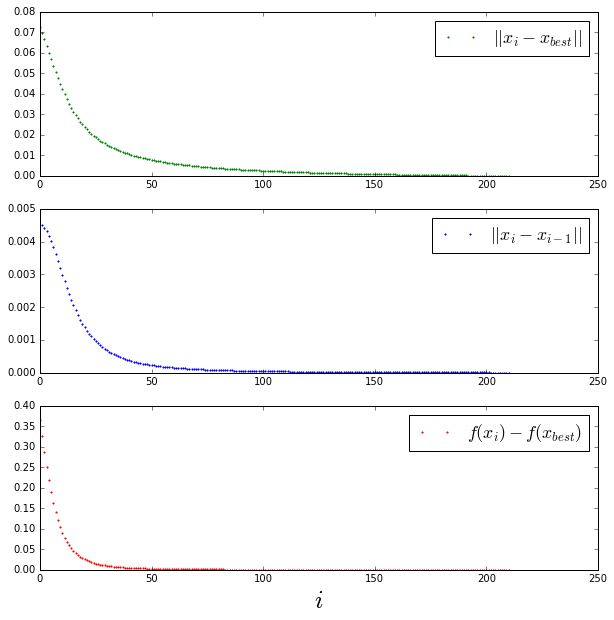

In [84]:
method_info(y)

# Frank-Wolfe
$X=B_1^{||\cdot||_2}(0)$


$y_k=\arg\min\limits_{y\in X}\nabla^T f(x_k)y=-\frac{\nabla f(x_k)}{||\nabla f(x_k)||}$

$x_{k+1}=(1-\gamma_k)x_k+\gamma_ky_k$

1. 
$\gamma_1=1$
$\gamma_{k+1}=\gamma_k-\frac{\gamma_k^2}{2}$

2. $\gamma_k=\frac{2}{k+1}$

In [97]:
def y(x):
    return(-grad(x)/linalg.norm(grad(x)))

In [131]:
def FW(gamma_method = "old"):
    x = list()
    x.append(np.zeros(n))

    k = 0

    #x_norm = 1e-7

    gamma1 = 1.

    while True:
        x.append(0)

        if gamma_method == "old":
            gamma = 2 / ((k + 1) + 1.)
        else:
            gamma = gamma1
            gamma1 = gamma1 - gamma1 ** 2 / 2

        x[k + 1] = (1 - gamma) * x[k] + gamma * y(x[k])

        #print k, gamma, func(x[k+1])

        norm_new = np.linalg.norm(grad(x[k + 1]))

        # Условия останова
        if norm_new < grad_norm:
            break

        if linalg.norm(x[k + 1] - x[k]) <= x_norm:
            break

        if k >= maxiter:
            break

        k += 1
    return(x)

Best: 101 f = -5.98484100526
Last: 102


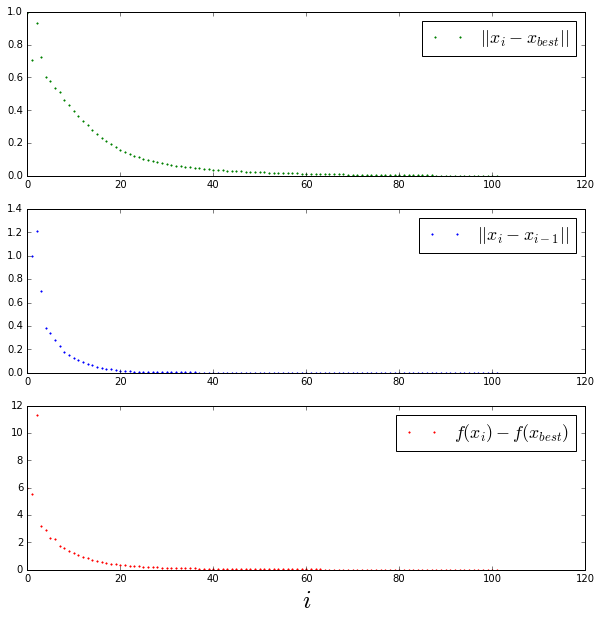

In [132]:
x = FW(gamma_method = "old")
method_info(x)

Best: 101 f = -5.98412950891
Last: 102


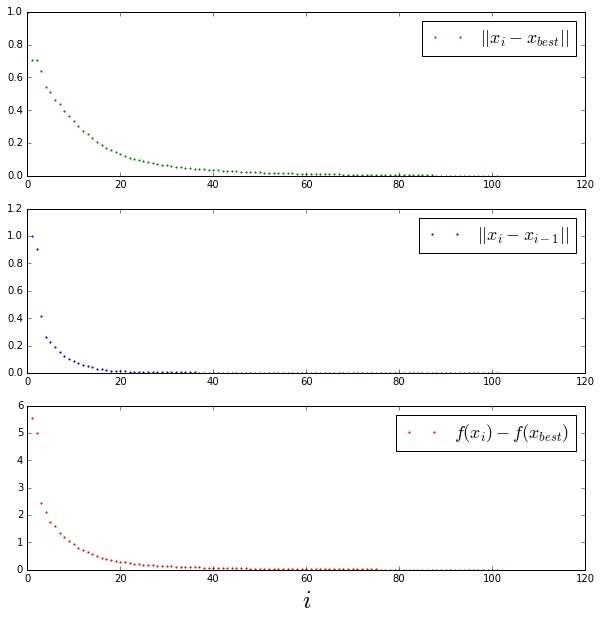

In [133]:
x = FW(gamma_method = "new")
method_info(x)